In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from math import sqrt

In [3]:
def openImg():
    iimm = np.array(cv2.imread("./Dataset/260058.jpg"))
    iimm = cv2.cvtColor(iimm, cv2.COLOR_BGR2RGB)
    iimm = cv2.cvtColor(iimm, cv2.COLOR_RGB2LAB)
    return iimm.astype(np.float32)


def plot_img(im):
    im = im.astype(np.uint8)
    im = cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    plt.imshow(im)
    plt.show()
    print("Done.")

def grad(img, x, y):
    if (x < 1 or x >= img.shape[0]-1 or y < 1 or y >= img.shape[1]-1):
        return 9223372036854775807
    A = pow(img[x+1][y][0] - img[x-1][y][0], 2) + pow(img[x+1][y][1] - img[x-1][y][1], 2) + pow(img[x+1][y][2] - img[x-1][y][2], 2)
    B = pow(img[x][y+1][0] - img[x][y-1][0], 2) + pow(img[x][y+1][1] - img[x][y-1][1], 2) + pow(img[x][y+1][2] - img[x][y-1][2], 2)
    return int((A + B) * 1000)

'''
def grad(image, i, j):
    i = min(i, image.shape[0] - 2)
    j = min(j, image.shape[1] - 2)
    return sqrt((image[i + 1, j] - image[i - 1, j]) ** 2 + (image[i, j + 1] - image[i, j - 1]) ** 2)
'''

def mingrad(img, x, y):
    d = {}
    d[grad(img, x-1, y-1)] = (x-1, y-1)
    d[grad(img, x,   y-1)] = (x,   y-1)
    d[grad(img, x+1, y-1)] = (x+1, y-1)
    d[grad(img, x-1, y)]   = (x-1, y)
    d[grad(img, x,   y)]   = (x  , y)
    d[grad(img, x+1, y)]   = (x+1, y)
    d[grad(img, x-1, y+1)] = (x-1, y+1)
    d[grad(img, x,   y+1)] = (x  , y+1)
    d[grad(img, x+1, y+1)] = (x+1, y+1)
    return d[min(d.keys())]   
    
def make_color_points(im, k):
    length = im.shape[0] * im.shape[1]
    s = int(np.sqrt(length / k))
    h = s//2
    w = s//2
    centers = []
    
    while h < im.shape[0]:
        while w < im.shape[1]:
            centers.append((h, w))
            w += s
        w = s//2
        h += s
    
    return centers
    


def plot_points_to_img(im, color_points):
    plt.imshow(compute_gradient(im).astype(np.uint8))
    for elm in color_points:
        plt.scatter(elm[0], elm[1], marker='o')
    plt.show()


def lab_dist(arr1, arr2):
    return sqrt(pow(arr1[0] - arr2[0], 2) + pow(arr1[1] - arr2[1], 2) + pow(arr1[2] - arr2[2], 2))

def xy_dist(arr1, arr2):
    return sqrt(pow(arr1[0] - arr2[0], 2) + pow(arr1[1] - arr2[1], 2))


def distance_color(coordpoint, colorpoint, coordcenter, colorcenter, s):
    m = 40
    dlab = lab_dist(colorcenter, colorpoint)
    dxy = xy_dist(coordcenter, coordpoint)
    cooef = m / s
    return dlab + cooef * dxy

def moy_tuple(l):
    x = 0
    y = 0
    for e in l:
        x += e[1]
        y += e[0]
    x = x//len(l)
    y = y//len(l)
    return (y, x)

def make_image(im, color_points, k):
    img_height = im.shape[0]
    img_width = im.shape[1]
    length = img_width * img_height
    S = int(np.sqrt(length / k))
    SS = 2*S
    res = np.zeros(im.shape)
    
    d = {}
    for i in range(len(color_points)):
        d[i] = []

    count = 2
    #change = True
    while count > 0:
        #change = False
        count -= 1
        
        for i in range(img_height):
            for j in range(img_width):
                c_i = 0
                c_x = 0
                c_y = 0
                d_min = 9223372036854775807
                for k, c in enumerate(color_points):
                    if c[0] > i-SS and c[0] < i+SS and c[1] > j-SS and c[1] < j+SS:
                        dist = distance_color((i, j), im[i][j], c, im[c[0]][c[1]], S)
                        if dist < d_min:
                            d_min = dist
                            c_y = c[0]
                            c_x = c[1]
                            c_i = k

                if (c_x == 0 and c_y == 0) or (i, j) in d[c_i]:
                    continue
                    
                if np.not_equal(res[i][j], [0, 0, 0]).any():
                    for k in range(len(color_points)):
                        if (i, j) in d[k]:
                            d[k].remove((i, j))
                            break;
                res[i][j] = im[c_y][c_x]
                d[c_i].append((i, j))
                #change = True

        for k in range(len(color_points)):
            color_points[k] = moy_tuple(d[k])
            
    for i in range(img_height):
        for j in range(img_width):
            if np.equal(res[i][j], [0, 0, 0]).all():
                c_i = 0
                c_x = 0
                c_y = 0
                d_min = 9223372036854775807
                for k, c in enumerate((i-1, j), (i, j-1), (i+1, j), (i,j+1)):
                    dist = distance_color((i, j), im[i][j], c, im[c[0]][c[1]], S)
                    if dist < d_min:
                        d_min = dist
                        c_y = c[0]
                        c_x = c[1]
                        c_i = k
                res[i][j] = im[c_y][c_x]
                d[c_i].append((i, j))
            
    return res

def add_points_to_img(im, color_points):
    im = im.astype(np.uint8)
    im = cv2.cvtColor(im, cv2.COLOR_LAB2RGB)
    plt.imshow(im)
    for elm in color_points:
        plt.scatter(elm[1], elm[0], marker='o')
    plt.show()

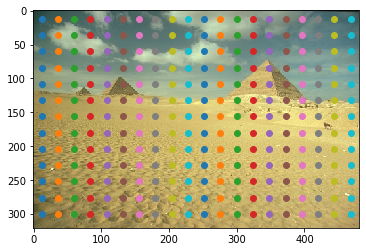

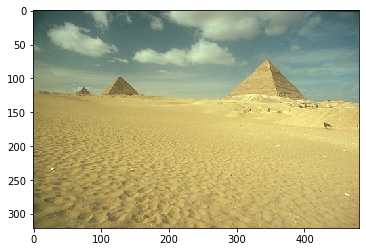

Done.


In [4]:
def main():
    
    im = openImg()
    nb_point = 250
    
    color_points = make_color_points(im, nb_point)
    #im = make_image(im, color_points, nb_point)
    img_points = add_points_to_img(im, color_points)

    plot_img(im)    


if __name__ == '__main__':
    main()